# Evaluation of 1 Model With Physgen

In [1]:
model_1 = "pix2pix_1_0_residual_few_bui_masked_weight_loss"  # pix2pix_1_0_residual_few_bui_weight_loss, pix2pix_1_0_residual_few_bui_masked_weight_loss
model_1_type = "pix2pix"  # hexa_wave_net, pix2pix, pix2pix_cfo
# for Hexa-Wave Net
model_variation = 1  # 1, 2, 3, 7, 8

data_1 = "../../data/nms1000_test_residual_reflection"
data_1_type = "noise"  # physgen, noise
physgen_variation = "sound_reflection"    # sound_baseline, sound_reflection, sound_diffraction, sound_combined
different_naming_1 = False

batch_size = 1
data_to_process_size = "inf"
image_size = 256

### Env Setup

In [2]:
# !conda create -n eval python=3.8 -y
# !conda activate eval

Activate now eval env and run:

In [3]:
# !pip install pandas
# !pip install ipython
# !pip install ipykernel
# !pip install opencv-python
# !pip install shapely
# !pip install pytorch-msssim
# !pip install scikit-image
# !pip install -r requirements.txt
# !pip install kornia

> Set 'eval' as your python env

### Imports

In [4]:
import os
import re
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import cv2

In [5]:
!python --version

Python 3.8.20


### Helper

In [6]:
def imshow(img, title=None, image_width=10, axis=False,
           color_space="RGB", cmap=None, cols=1, save_to=None,
           hspace=0.2, wspace=0.2,
           use_original_sytle=False, invert=False):
    """
    Visualizes one or multiple images.

    Image will be reshaped: [batch_size/images, width, height, channels]

    ---
    Parameters:
    - img : np.ndarray
        Images/Images with [width, height, channels] or for multiple: [batch_size/images, width, height, channels].
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    """
    original_style = plt.rcParams.copy()

    img_shape = img.shape
    print(f"Got images with shape: {img_shape}")

    # tranform the image to the right form
    if len(img_shape) == 2:
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], 1))
    elif len(img_shape) == 3:
        # check if multiple gray images or multiple images with channel
        # if img.shape[2] < img.shape[0] and img.shape[1] == img.shape[2]:
        img = np.reshape(img, shape=(1, img.shape[0], img.shape[1], img.shape[2]))
        # else:
        #     # there could be cases where this is wrong
        #     img = np.reshape(img, shape=(img.shape[0], img.shape[1], img.shape[2], 1))
    elif len(img_shape) != 4:
        raise ValueError(f"Image(s) have wrong shape! Founded shape: {img.shape}.")

    print(f"Transformed shape to: {img_shape}")

    # invert images
    if invert:
        print("Invert images...")
        max_value = 2**(img.dtype.itemsize * 8) -1
        scaling_func = lambda x: max_value - x
        img = np.apply_along_axis(scaling_func, axis=0, arr=img)

    # Set visualization settings
    # aspect_ratio_width = img.shape[1] / img.shape[2]
    aspect_ratio = img.shape[2] / img.shape[1]

    n_images = img.shape[0]
    rows = n_images//cols + int(n_images % cols > 0)

    width = int(image_width * cols)
    height = int(image_width * rows * aspect_ratio)

    # set plt style
    if not use_original_sytle:
        plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
        plt.style.use(plt_style)
        print(f"Using '{plt_style}' plotting style.")

    # plotting
    print(f"Making you a beautiful plot...")
    fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(width, height))
    try:
        ax = ax.ravel()
    except AttributeError:
        ax = [ax]
    fig.subplots_adjust(hspace=hspace, wspace=wspace)
    if type(title) == str:
        fig.suptitle(title, fontsize=128, y=0.95)

    for idx in range(len(ax)):
        cur_ax = ax[idx]

        if idx >= len(img):
            cur_ax.axis("off")
            continue

        cur_img = img[idx]

        if color_space.lower() == "bgr":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2RGB)
            used_cmap = None
        elif color_space.lower() == "rgb":
            cur_img = cur_img
            used_cmap = None
        elif color_space.lower() == "hsv":
            cur_img = cv2.cvtColor(cur_img, cv2.COLOR_HSV2RGB)
            used_cmap = None
        elif color_space.lower() in ["gray", "grey", "g"]:
            if len(cur_img.shape) == 3 and cur_img.shape[2]:
                cur_img = cv2.cvtColor(cur_img, cv2.COLOR_RGB2GRAY)
            else:
                cur_img = cur_img
            print(cur_img.shape)
            used_cmap = "gray"

        if cmap:
            used_cmap = cmap

        if type(title) in [list, tuple]:
            cur_ax.set_title(title[idx], fontsize=64)
        if axis == False:
            cur_ax.axis("off")

        cur_ax.imshow(cur_img, cmap=used_cmap)

    if save_to:
        os.makedirs(os.path.split(save_to)[0], exist_ok=True)
        fig.savefig(save_to, dpi=300)

    plt.show()

    if not use_original_sytle:
        # reset to original plt style
        plt.rcParams.update(original_style)

def show_images(image_paths:list, title=None, image_width=5, axis=False,
                color_space="gray", cmap=None, 
                cols=2, save_to=None,
                hspace=0.01, wspace=0.01,
                use_original_sytle=False, invert=False):
    """
    Visulalizes/shows one or multiple images.

    ---
    Parameters:
    - image_paths : List[str]
        List of paths to the images which should get visualized.
    - title : str, optional (default=None)
        Title of the whole plot.
    - image_width : int, optional (default=5)
        Width of one image in the plot.
    - axis : bool, optional (default=False)
        Whether to print the axis of the images or not.
    - color_space : str, optional (default="RGB")
        The colorspace of the image: RGB, BGR, gray, HSV.
    - cmap : str, optional (default=None)
        Which cmap to use. Check all cmaps here out: https://matplotlib.org/stable/users/explain/colors/colormaps.html
    - cols : int, optional (default=1)
        Amount of columns in the plot.
    - save_to : str, optional (default=None)
        Path where to save the result image.
    - hspace : float, optional (default=0.01)
        Horizontal space between the images.
    - wspace : float, optional (default=0.01)
        Vertical space between the images.
    - use_original_sytle : bool, optonial (default=False)
        Whether the plot should use the current active matplotlib style or choosing a own one. 
    - invert : bool, optional (default=False)
        Whether to invert the images or not.
    """
    if color_space.lower() == "rgb":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in image_paths])
    elif color_space.lower() == "hsv":
        images = np.array([cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2HSV) for img in image_paths])
    else:
        images = np.array([cv2.imread(img) for img in image_paths])
    imshow(images, title=title, image_width=image_width, axis=axis,
           color_space=color_space, cmap=cmap, cols=cols, save_to=save_to,
           hspace=hspace, wspace=wspace,
           use_original_sytle=use_original_sytle, invert=invert)
    return images

### Run Tests

In [7]:
command = (
  f"python test.py "
  f"--dataroot {data_1} "
  f"--name {model_1} "
  f"--model {model_1_type} "
  f"--batch_size {batch_size} "
  f"--dataset_mode {data_1_type} "
  f"--input_nc 1 "
  f"--output_nc 1 "
  f"--load_size {image_size} "
  f"--netG unet_256 "
  f"--max_dataset_size {data_to_process_size} "
  f"--num_test {data_to_process_size} "
  f"--results_dir ./eval/{model_1} "
  f"--phase test "
  f"--eval"
)

if model_variation == "hexa_wave_net":
  command += f" --model_type {model_variation}"

if different_naming_1:
  command += " --different_building_naming"

if data_1_type == "physgen":
  command += f" --variation {physgen_variation}"

# Finally run it
!{command}

/home/tippolit/anaconda3/envs/eval/lib/python3.8/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: ../../data/nms1000_test_residual_reflection	[default: None]
             dataset_mode: noise                         	[default: aligned]
different_building_naming: False                         
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: True         

### Extract Test Predictions

In [8]:
evaluation_path = f"./eval/{model_1}/{model_1}/test_latest/images"
target_path = f"../../data/eval/{model_1}"

In [9]:
!python eval_extractor.py \
    --name {model_1} \
    --evaluation_path {evaluation_path} \
    --target_path {target_path}

[info] copied real from './eval/pix2pix_1_0_residual_few_bui_masked_weight_loss/pix2pix_1_0_residual_few_bui_masked_weight_loss/test_latest/images/buildings_929_real_B.png' to '../../data/eval/pix2pix_1_0_residual_few_bui_masked_weight_loss/real/buildings_929.png'
[info] copied pred from './eval/pix2pix_1_0_residual_few_bui_masked_weight_loss/pix2pix_1_0_residual_few_bui_masked_weight_loss/test_latest/images/buildings_68_fake_B.png' to '../../data/eval/pix2pix_1_0_residual_few_bui_masked_weight_loss/pred/buildings_68.png'
[info] copied pred from './eval/pix2pix_1_0_residual_few_bui_masked_weight_loss/pix2pix_1_0_residual_few_bui_masked_weight_loss/test_latest/images/buildings_595_fake_B.png' to '../../data/eval/pix2pix_1_0_residual_few_bui_masked_weight_loss/pred/buildings_595.png'
[info] copied real from './eval/pix2pix_1_0_residual_few_bui_masked_weight_loss/pix2pix_1_0_residual_few_bui_masked_weight_loss/test_latest/images/buildings_70_real_B.png' to '../../data/eval/pix2pix_1_0_res

### Calc Eval metrics

In [10]:
!python eval_metrics.py \
    --data_dir ../../data/eval/{model_1}/real \
    --pred_dir ../../data/eval/{model_1}/pred \
    --osm_dir ../../data/eval/{model_1}/osm \
    --output ./eval_results/evaluation_{model_1}.csv

Evaluating samples: 100%|███████████████████| 1000/1000 [00:20<00:00, 47.94it/s]
               MAE         MAPE      LoS_MAE  NLoS_MAE    LoS_wMAPE  NLoS_wMAPE
count  1000.000000  1000.000000  1000.000000    1000.0  1000.000000      1000.0
mean      0.312511     0.797060     0.312515       0.0     0.797072         0.0
std       0.321643     0.927174     0.321648       0.0     0.927188         0.0
min       0.003884     0.007816     0.003884       0.0     0.007816         0.0
25%       0.082686     0.167897     0.082688       0.0     0.167899         0.0
50%       0.195041     0.418764     0.195044       0.0     0.418770         0.0
75%       0.453099     1.130103     0.453106       0.0     1.130121         0.0
max       2.303855     7.226974     2.303891       0.0     7.227084         0.0


### Show Results

In [11]:
mae_model_1_name = f'MAE_{model_1}'
los_mae_model_1_name = f'LoS_MAE_{model_1}'
nlos_mae_model_1_name = f'NLoS_MAE_{model_1}'
mape_model_1_name = f'MAPE_{model_1}'
los_wmape_model_1_name = f'LoS_wMAPE_{model_1}'
nlos_wmape_model_1_name = f'NLoS_wMAPE_{model_1}'

In [12]:
df_1 = pd.read_csv(f"./eval_results/evaluation_{model_1}.csv")
# df_1 = df_1.drop(columns=["LoS_MAE", "NLoS_MAE", "LoS_wMAPE", "NLoS_wMAPE"])
df_1 = df_1.rename(columns={'MAE': mae_model_1_name, 
                            'LoS_MAE': los_mae_model_1_name,
                            'NLoS_MAE': nlos_mae_model_1_name,
                            'MAPE':mape_model_1_name,
                            'LoS_wMAPE': los_wmape_model_1_name,
                            'NLoS_wMAPE': nlos_wmape_model_1_name
                            }
                   )
# extract sample_ids
sample_id_series = df_1["sample_id"].str.extract(r'^(\d+)_')[0]
if sample_id_series.isna().sum() > 1:
    sample_id_series = df_1["sample_id"].str.extract(r'(\d+)')[0]
if sample_id_series.isna().sum() > 1:
    raise ValueError(f"Found {sample_id_series.isna().sum()} Nans")
df_1["sample_id"] = sample_id_series
print("Nan found in sample ids:", df_1["sample_id"].isna().sum())
df_1 = df_1.dropna(subset=["sample_id"])
df_1["sample_id"] = df_1["sample_id"].astype(int)
merged_df = df_1
df_1

Nan found in sample ids: 0


,sample_id,MAE_pix2pix_1_0_residual_few_bui_masked_weight_loss,MAPE_pix2pix_1_0_residual_few_bui_masked_weight_loss,LoS_MAE_pix2pix_1_0_residual_few_bui_masked_weight_loss,NLoS_MAE_pix2pix_1_0_residual_few_bui_masked_weight_loss,LoS_wMAPE_pix2pix_1_0_residual_few_bui_masked_weight_loss,NLoS_wMAPE_pix2pix_1_0_residual_few_bui_masked_weight_loss
0,893,0.096172,0.193749,0.096174,0.0,0.193751,0.0
1,109,0.508860,1.247456,0.508868,0.0,1.247475,0.0
2,788,1.306386,4.148700,1.306406,0.0,4.148763,0.0
3,974,0.220271,0.449864,0.220275,0.0,0.449871,0.0
4,570,0.041498,0.083114,0.041499,0.0,0.083115,0.0
...,...,...,...,...,...,...,...
995,247,0.113807,0.280794,0.113808,0.0,0.280798,0.0
996,717,0.165429,0.346467,0.165432,0.0,0.346472,0.0
997,366,0.195415,0.418780,0.195418,0.0,0.418787,0.0
998,503,0.235841,0.654176,0.235845,0.0,0.654186,0.0


Using 'seaborn-v0_8' plotting style.

MAE
    - pix2pix_1_0_residual_few_bui_masked_weight_loss: 0.31

MAPE
    - pix2pix_1_0_residual_few_bui_masked_weight_loss: 0.80

LoS MAE
    - pix2pix_1_0_residual_few_bui_masked_weight_loss: 0.31

NLoS MAE
    - pix2pix_1_0_residual_few_bui_masked_weight_loss: 0.00

LoS wMAPE
    - pix2pix_1_0_residual_few_bui_masked_weight_loss: 0.80

NLoS wMAPE
    - pix2pix_1_0_residual_few_bui_masked_weight_loss: 0.00


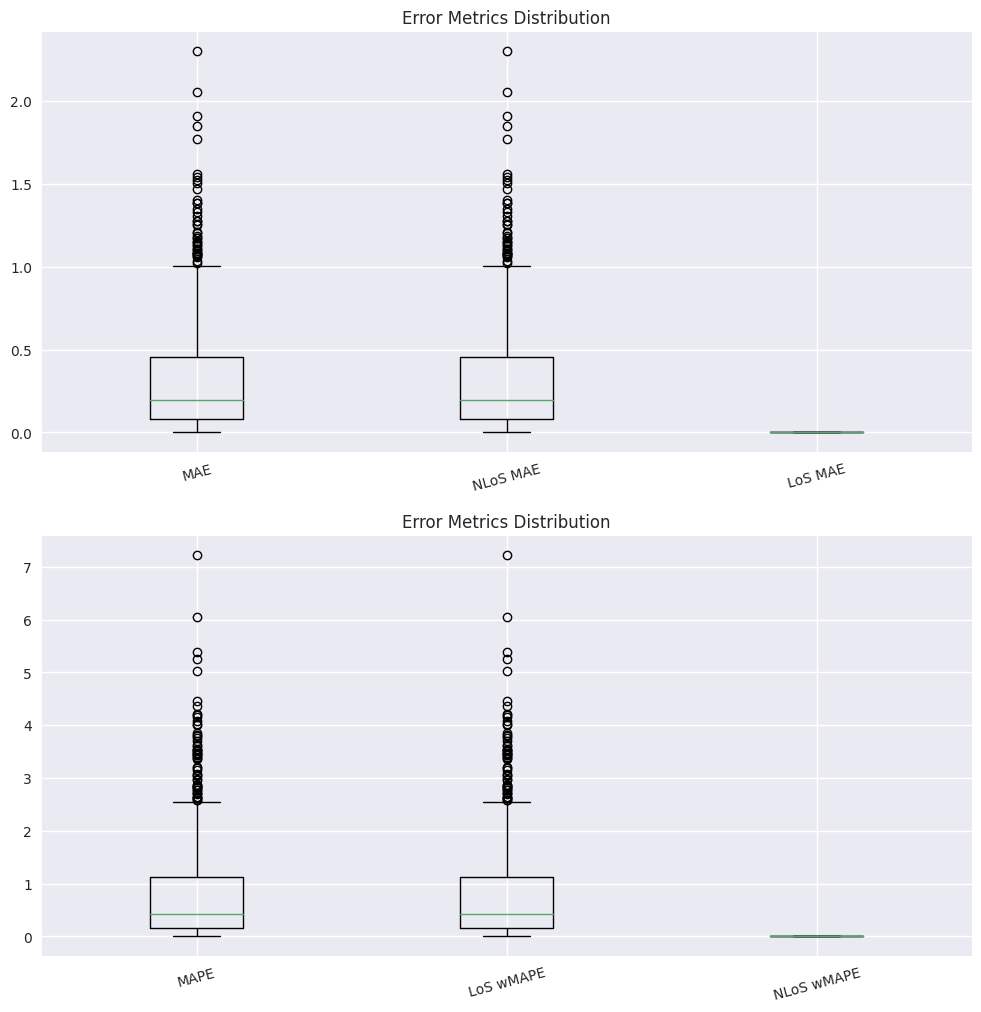

In [13]:
plt_style = 'seaborn-v0_8' if 'seaborn-v0_8' in plt.style.available else np.random.choice(plt.style.available)
plt.style.use(plt_style)
print(f"Using '{plt_style}' plotting style.")

values_0 = [
    merged_df[mae_model_1_name],
    merged_df[los_mae_model_1_name],
    merged_df[nlos_mae_model_1_name],
]

labels_0 = [
    "MAE",
    "NLoS MAE",
    "LoS MAE"
]

values_1 = [
    merged_df[mape_model_1_name],
    merged_df[los_wmape_model_1_name],
    merged_df[nlos_wmape_model_1_name]
]

labels_1 = [
    "MAPE",
    "LoS wMAPE",
    "NLoS wMAPE"
]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
ax[0].boxplot(values_0, notch=False)
ax[0].set_xticks(range(1, len(labels_0) + 1))
ax[0].set_xticklabels(labels_0, rotation=15)
ax[0].set_title("Error Metrics Distribution")

ax[1].boxplot(values_1, notch=False)
ax[1].set_xticks(range(1, len(labels_1) + 1))
ax[1].set_xticklabels(labels_1, rotation=15)
ax[1].set_title("Error Metrics Distribution")



print(f"\nMAE\n    - {model_1}: {merged_df[mae_model_1_name].mean():>0.2f}")
print(f"\nMAPE\n    - {model_1}: {merged_df[mape_model_1_name].mean():>0.2f}")
print(f"\nLoS MAE\n    - {model_1}: {merged_df[los_mae_model_1_name].mean():>0.2f}")
print(f"\nNLoS MAE\n    - {model_1}: {merged_df[nlos_mae_model_1_name].mean():>0.2f}")
print(f"\nLoS wMAPE\n    - {model_1}: {merged_df[los_wmape_model_1_name].mean():>0.2f}")
print(f"\nNLoS wMAPE\n    - {model_1}: {merged_df[nlos_wmape_model_1_name].mean():>0.2f}")

Example Image

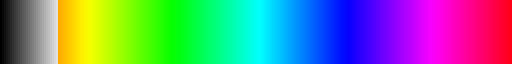

In [14]:
from matplotlib.colors import ListedColormap

def get_unique_hsv_cmap():
    unique_hsv_map = plt.get_cmap("hsv")(np.linspace(0, 1, 256))    # np.arange(0, 256)
    hsv_map = plt.get_cmap("hsv")
    for cur_idx in range(256):
        r, g, b, a = hsv_map(cur_idx)
        if r > 0.99 and g < (170/255):
            gray_value = cur_idx*8 / 255.0
            unique_hsv_map[cur_idx] = (gray_value, gray_value, gray_value, 1.0)
        else:
            break
    unique_hsv = ListedColormap(unique_hsv_map)
    plt.colormaps.register(name="unique_hsv", cmap=unique_hsv, force=True)
    return unique_hsv

get_unique_hsv_cmap()
plt.get_cmap("unique_hsv")

In [15]:
def get_same_pred_real_samples(pred_path:str, real_path:str, input_path:str, n_samples:int, ids=None):
    if not ids:
        # choose n random samples
        samples = random.sample(os.listdir(pred_path), n_samples)
        pred_samples = [os.path.join(pred_path, cur_image) for cur_image in samples]

        # get the used id's
        ids = []
        for cur_image in samples:
            cur_id = re.findall(r'\d+', string=cur_image)
            if len(cur_id) <= 0:
                raise ValueError(f"One image has no ID: {cur_image}")
            cur_id = cur_id[-1]
            ids += [cur_id]
    else:
        # get pred image
        pred_image_samples = []
        for target_id in ids:
            found = False
            for cur_image in os.listdir(real_path):
                cur_id = re.findall('\d+', string=cur_image)
                cur_id = cur_id[-1]
                if cur_id == target_id:
                    pred_image_samples += [cur_image]
                    found = True
                    break

            if not found:
                raise ValueError(f"Does not found pred image with id: {target_id}")
        pred_samples = [os.path.join(pred_path, cur_image) for cur_image in pred_image_samples]

    # get real image
    real_image_samples = []
    for target_id in ids:
        found = False
        for cur_image in os.listdir(real_path):
            cur_id = re.findall('\d+', string=cur_image)
            cur_id = cur_id[-1]
            if cur_id == target_id:
                real_image_samples += [cur_image]
                found = True
                break

        if not found:
            raise ValueError(f"Does not found real image with id: {target_id}")

    target_samples = [os.path.join(real_path, cur_image) for cur_image in real_image_samples]

    # get real image
    input_image_samples = []
    if input_path:
        for target_id in ids:
            found = False
            for cur_image in os.listdir(input_path):
                cur_id = re.findall('\d+', string=cur_image)
                cur_id = cur_id[-1]
                if cur_id == target_id:
                    input_image_samples += [cur_image]
                    found = True
                    break

            if not found:
                raise ValueError(f"Does not found input image with id: {target_id}")

    input_samples = [os.path.join(input_path, cur_image) for cur_image in input_image_samples]

    return input_samples, target_samples, pred_samples, ids

In [16]:
def plot(ax, path, title="", sub_image=None, cmap="plasma", plot=True, vmin=None, vmax=None):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = 255 - img

    if sub_image:
        img_2 = cv2.imread(sub_image, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        img_2 = 255 - img_2

        assert img_2.shape == img.shape, "Shape mismatch"
        img = np.abs(img - img_2)
        # img = img - img_2
        # img[img < 0] = img[img < 0] * -1

    if plot:
        ax.axis("off")
        color_ax = ax.imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_title(title)
        plt.colorbar(color_ax, ax=ax, fraction=0.046, pad=0.04)
    
    return img

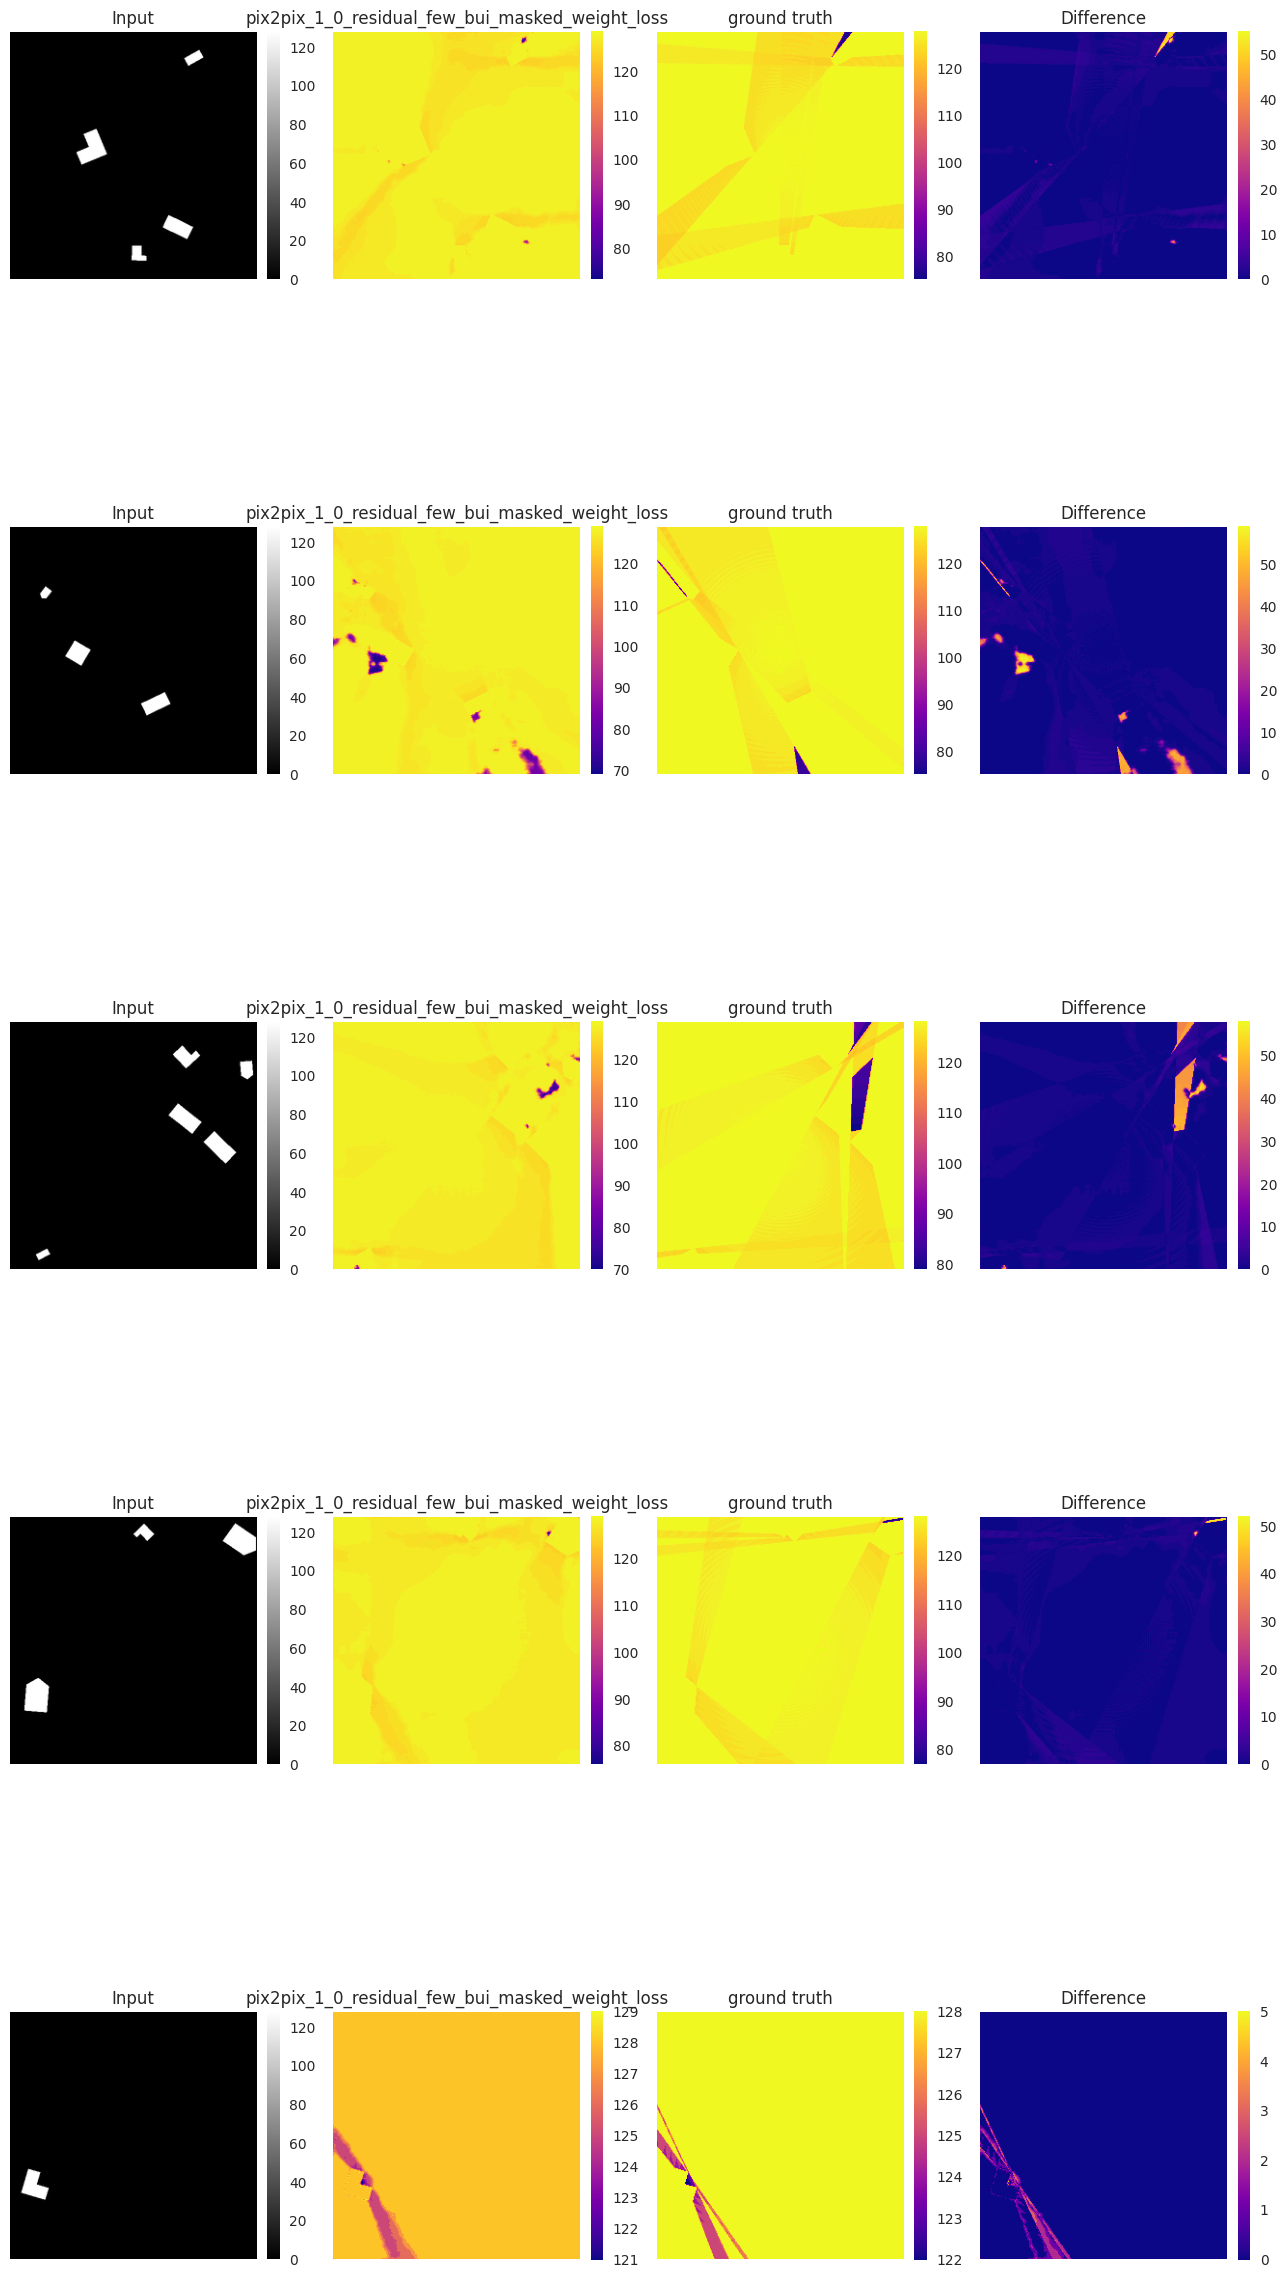

In [17]:
n_samples = 5

input_samples, real, pred_model, ids = get_same_pred_real_samples(f"../../data/eval/{model_1}/pred",
                                                                  f"../../data/eval/{model_1}/real",
                                                                  f"../../data/eval/{model_1}/osm",
                                                                  n_samples)


fig, ax = plt.subplots(nrows=n_samples, ncols=4, figsize=(4*4, n_samples*6))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(input_samples):
    plot(ax[idx][0], path=cur_path, title=f"Input", cmap="gray")

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][1], path=cur_path, title=f"{model_1}")

for idx, cur_path in enumerate(real):
    plot(ax[idx][2], path=cur_path, title=f"ground truth")

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][3], path=cur_path, title=f"Difference", sub_image=real[idx])

plt.subplots_adjust(hspace=0.5)

plt.show();

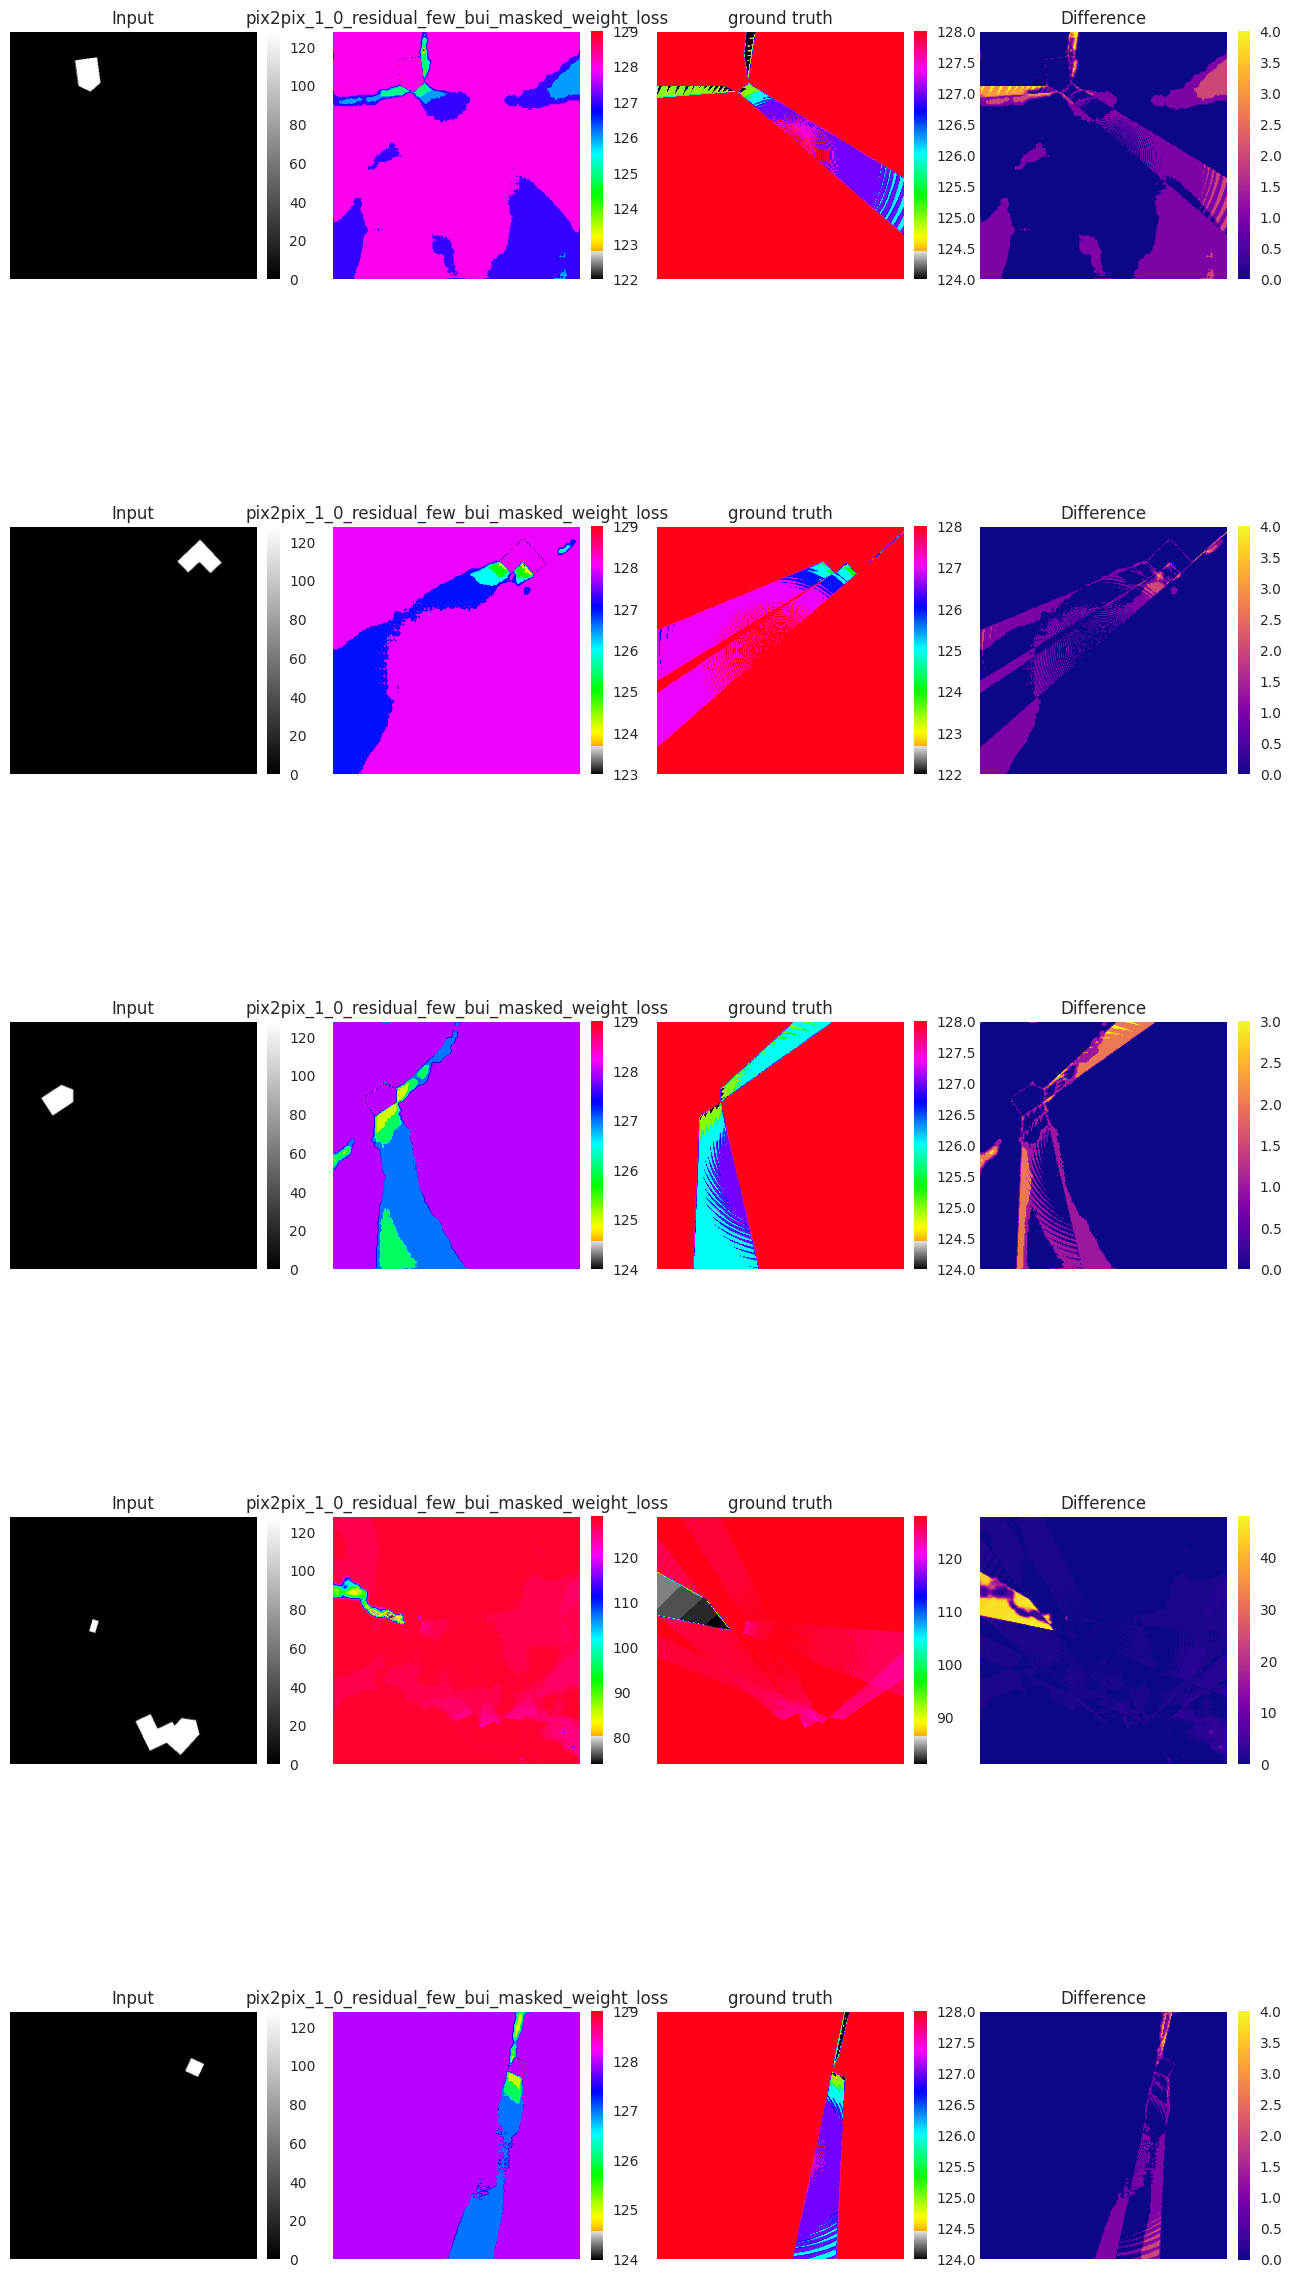

In [18]:
n_samples = 5

input_samples, real, pred_model, ids = get_same_pred_real_samples(f"../../data/eval/{model_1}/pred",
                                                                  f"../../data/eval/{model_1}/real",
                                                                  f"../../data/eval/{model_1}/osm",
                                                                  n_samples)


fig, ax = plt.subplots(nrows=n_samples, ncols=4, figsize=(4*4, n_samples*6))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(input_samples):
    plot(ax[idx][0], path=cur_path, title=f"Input", cmap="gray")

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][1], path=cur_path, title=f"{model_1}", cmap="unique_hsv")

for idx, cur_path in enumerate(real):
    plot(ax[idx][2], path=cur_path, title=f"ground truth", cmap="unique_hsv")

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][3], path=cur_path, title=f"Difference", sub_image=real[idx])

plt.subplots_adjust(hspace=0.5)

plt.show();

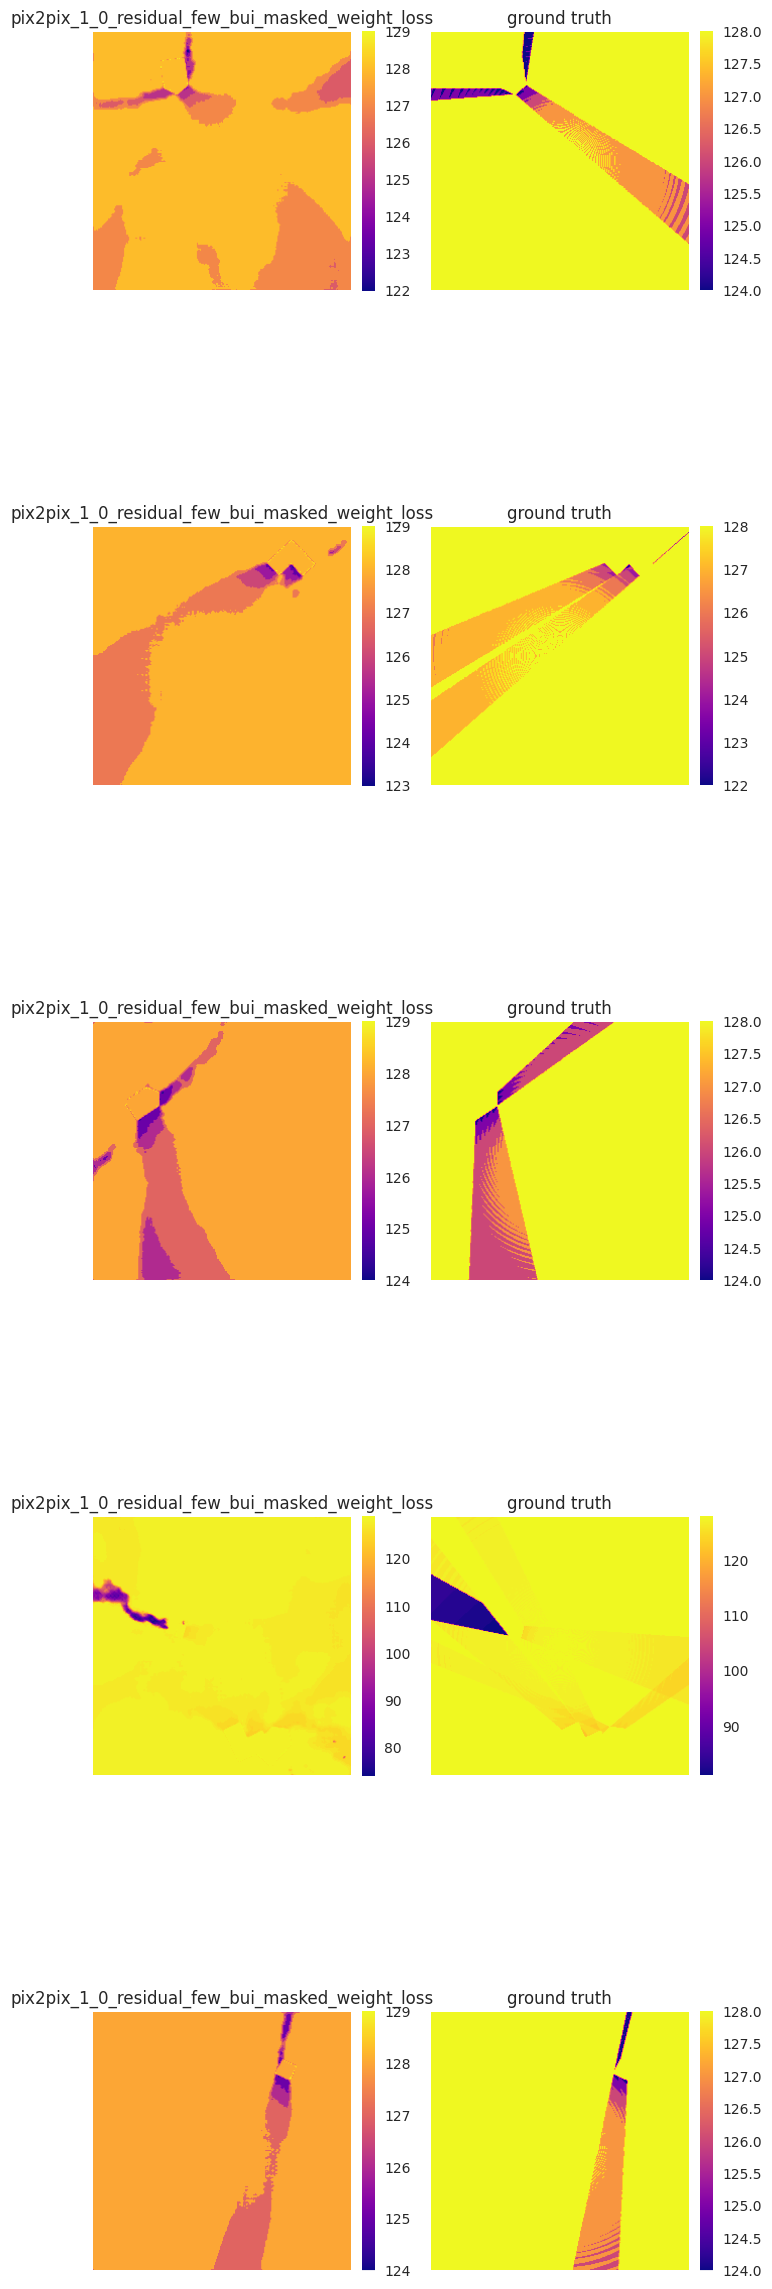

In [19]:
fig, ax = plt.subplots(nrows=n_samples, ncols=2, figsize=(2*4, n_samples*6))
# ax = ax.ravel()

ax_idx = 0

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx][0], path=cur_path, title=f"{model_1}")

for idx, cur_path in enumerate(real):
    plot(ax[idx][1], path=cur_path, title=f"ground truth")

plt.subplots_adjust(hspace=0.5)

plt.show();

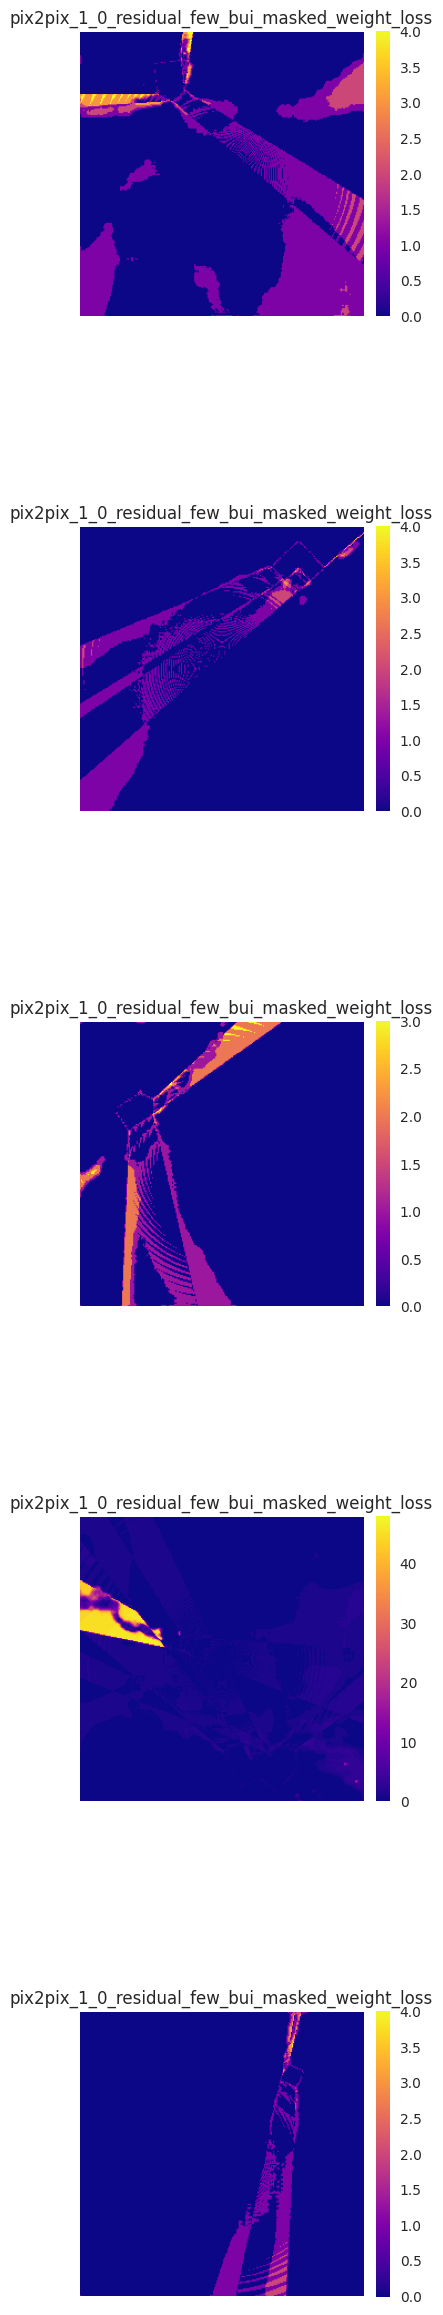

In [20]:
fig, ax = plt.subplots(nrows=n_samples, ncols=1, figsize=(1*4, n_samples*6))

for idx, cur_path in enumerate(pred_model):
    plot(ax[idx], path=cur_path, title=f"{model_1}", sub_image=real[idx], cmap="plasma")

plt.subplots_adjust(hspace=0.5)
plt.show();

Inspect some single images in more detail here:

In [21]:
from skimage.measure import block_reduce

def plot_image_with_values(img, block_size=8):
    # Compute mean over non-overlapping blocks
    mean_img = block_reduce(img, block_size=(block_size, block_size), func=np.mean)
    max_value = mean_img.max()

    # Plot the mean image
    plt.imshow(mean_img, cmap='gray', interpolation='nearest')
    plt.colorbar(label='Mean Value')

    # Annotate each block with the mean
    for i in range(mean_img.shape[0]):
        for j in range(mean_img.shape[1]):
            val = mean_img[i, j]
            color = 'white' if val < max_value/1.5 else 'black'
            # color = int(255 - val)
            plt.text(j, i, f'{val:.1f}', ha='center', va='center',
                     color=color, fontsize=6)

    plt.title(f'Mean Values over {block_size}x{block_size} Blocks')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.show()

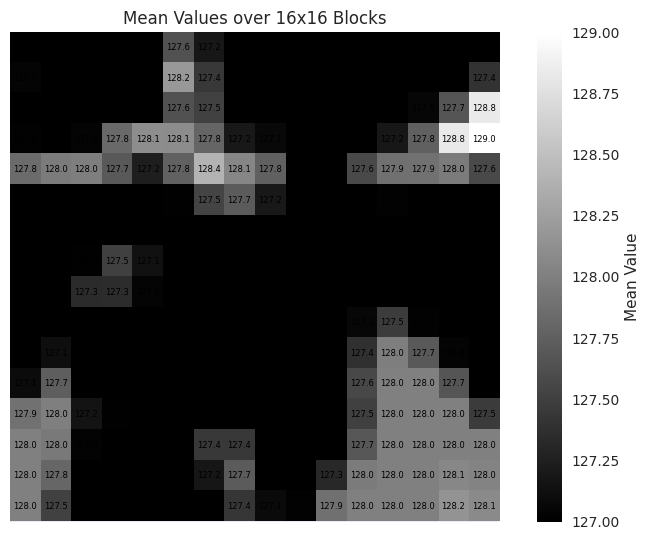

In [22]:
img_path = pred_model[0]
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE).astype(float)

plot_image_with_values(img, block_size=16)

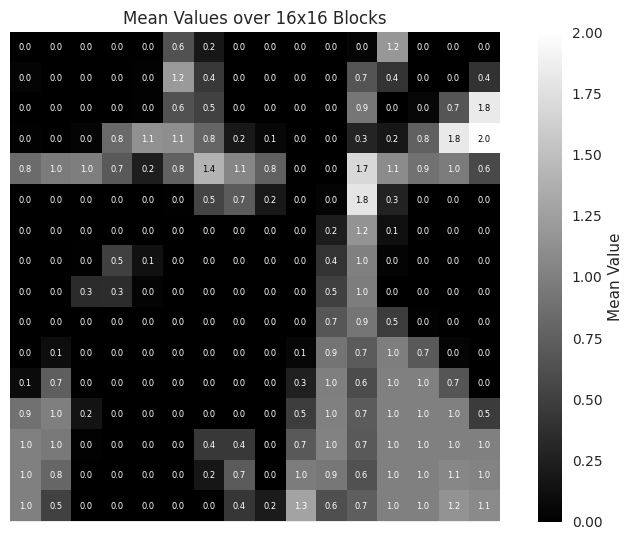

In [23]:
img = plot(None, path=pred_model[0], title=f"{model_1}", sub_image=real[idx], plot=False)
plot_image_with_values(img, block_size=16)